In [2]:
import numpy as np
import lightkurve as lk
import vetting as vt

In [3]:
# from model 
# https://drive.google.com/drive/folders/147fTY30M_TW7Z48y26LJJKhXM8_biDei
tic, sector = 173002823, [21, 48]
t0=2621.0300840
duration=4.3685156 / 24
period=23.08


In [4]:
download_dir = "../../data"

sr = lk.search_targetpixelfile(f"TIC {tic}", mission='TESS', sector=sector, cadence="short")
tpfs_all = sr.download_all(download_dir=download_dir)
print("TIC sector cadence(min), num. cadence")
for t in tpfs_all:
    print(f"TIC {t.targetid}", t.sector, f"{(np.median(np.diff(t.time.value)) * 24 * 60):.0f}", len(t))

TIC sector cadence(min), num. cadence
TIC 173002823 21 2 18758
TIC 173002823 48 2 18989


In [5]:
tpfs = tpfs_all[:]  # no more filtering needed
tpfs_nm = tpfs  # a copy of tpfs with no time masking

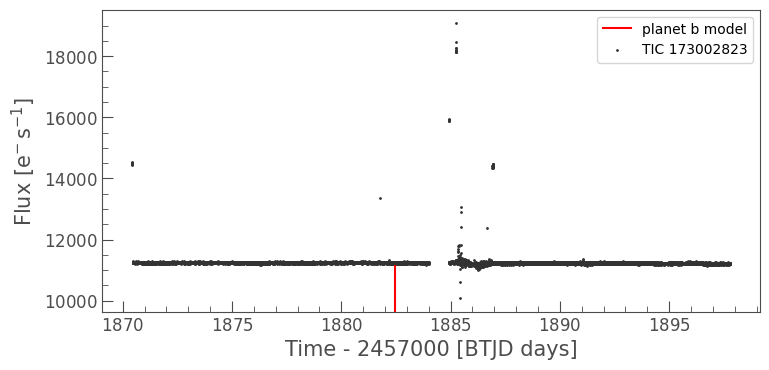

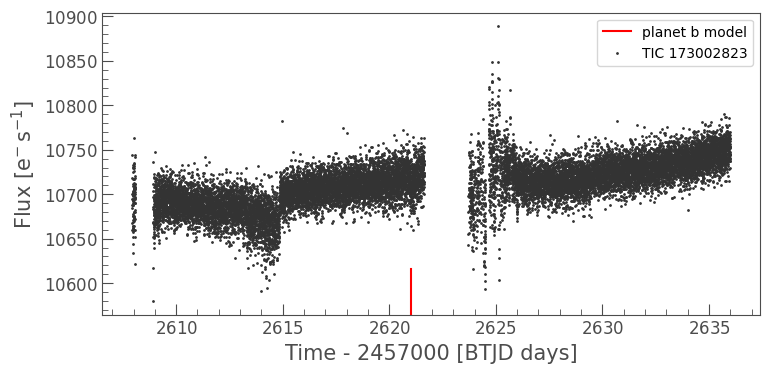

In [6]:
axs = [tpf.to_lightcurve().remove_outliers(sigma=7).scatter() for tpf in tpfs]
axs[0].axvline(t0 - period * 32, c='red', ymax=0.15, label="planet b model")
axs[-1].axvline(t0, c='red', ymax=0.15, label="planet b model");
[ax.legend() for ax in axs];

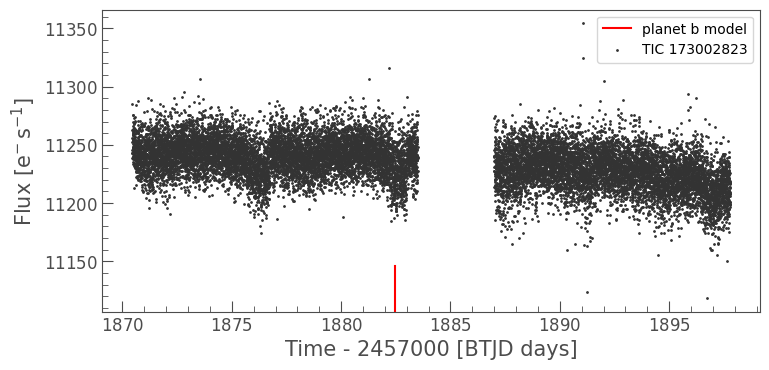

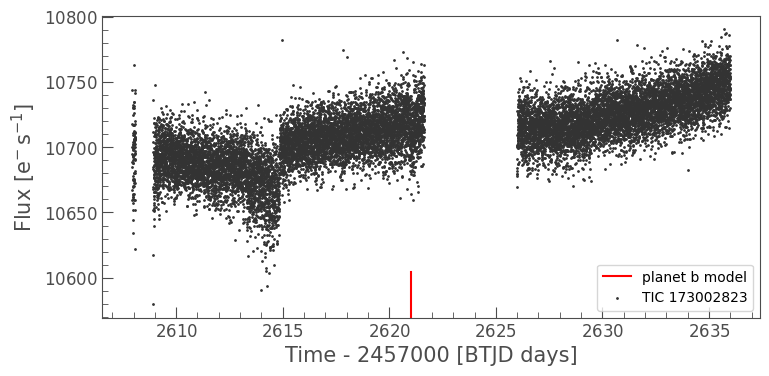

In [7]:
# mask out cadences with wild fluxes, in case they make the comparison weaker
# (e.g., they might make inflate the out-of-transit centroid variations)
# (it turns out make no noticeable difference)
tpfs = lk.TargetPixelFileCollection([
    tpfs_nm[0][(tpfs_nm[0].time.value < 1883.5) | (tpfs_nm[0].time.value > 1887)], 
    tpfs_nm[1][(tpfs_nm[1].time.value < 2623.5) | (tpfs_nm[1].time.value > 2626)]
])

# # only include cadences around the dips to reduce the variability of oot centroids
# tpfs = lk.TargetPixelFileCollection([
#     tpfs_nm[0][(t0 - period * 32 - duration * 4 < tpfs_nm[0].time.value) & (tpfs_nm[0].time.value < t0 - period * 32 + duration * 4)], 
#     tpfs_nm[1][(t0 - period *  0 - duration * 4 < tpfs_nm[1].time.value) & (tpfs_nm[1].time.value < t0 - period *  0 + duration * 4)], 
# ])


# axs[0].axvline(t0 - period * 32, c='red', ymax=0.15, label="planet b model")
# axs[-1].axvline(t0, c='red', ymax=0.15, label="planet b model");

axs = [tpf.to_lightcurve().remove_outliers(sigma=7).scatter() for tpf in tpfs]
axs[0].axvline(t0 - period * 32, c='red', ymax=0.15, label="planet b model")
axs[-1].axvline(t0, c='red', ymax=0.15, label="planet b model");
[ax.legend() for ax in axs];

([array([False]), array([ True])],
 [(0.37316803844353047,), (0.01315851896005152,)],
 [(0.37916028172136573,), (0.007787867861815217,)],
 [(0.3671757951656952,), (0.018529170058287824,)],
 dict_keys(['figs', 'pvalues', 'pvalues_x', 'pvalues_y', 'centroid_offset_detected', 'lc_list', 'tpf_m_list', 'diagnostics_figs']))

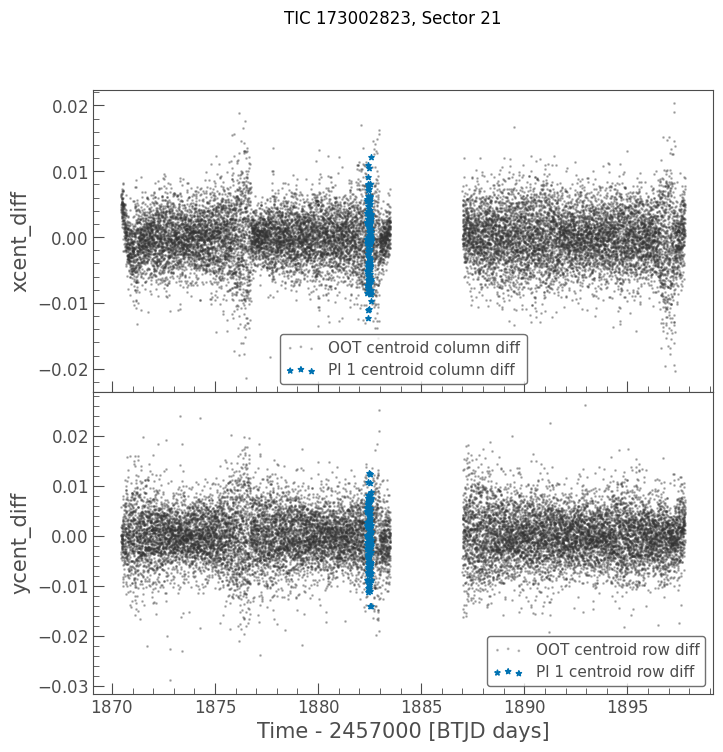

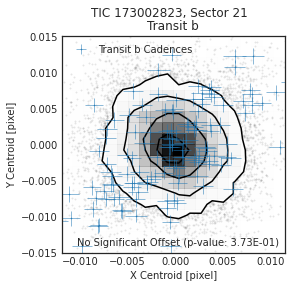

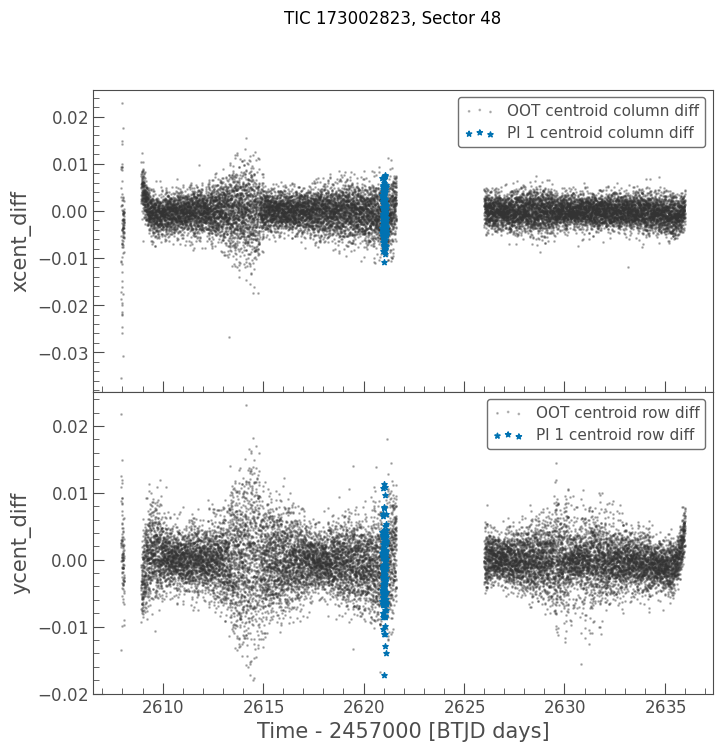

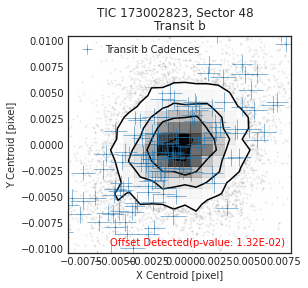

In [8]:
# if p-value is < 0.05 (5%), it means signficant centroid offset
# - distribution of centroid outside dips are not from the same population of the centroid during dips
r = vt.centroid_test(tpfs, period, t0, duration, aperture_mask='pipeline',
                     kernel=20 * 15 + 1,  # default is 21
                     plot=True,
                     include_diagnostics=True,
                    );
( 
    r['centroid_offset_detected'],
    r['pvalues'], 
    r['pvalues_x'],
    r['pvalues_y'],
    r.keys(), 
)

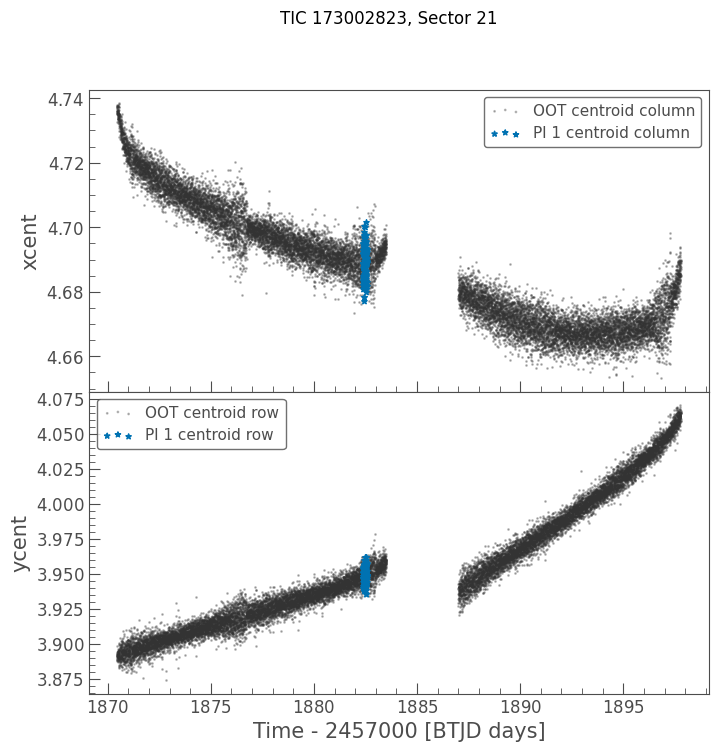

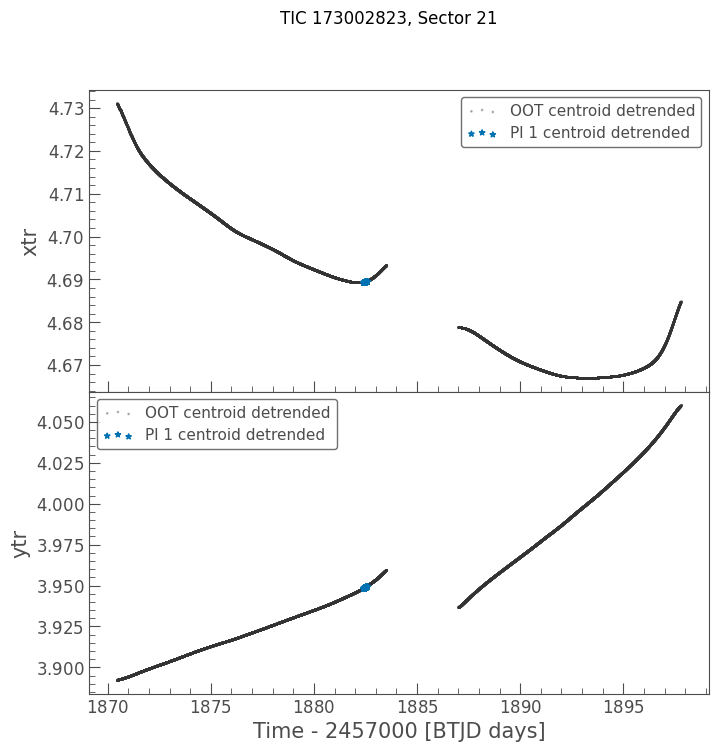

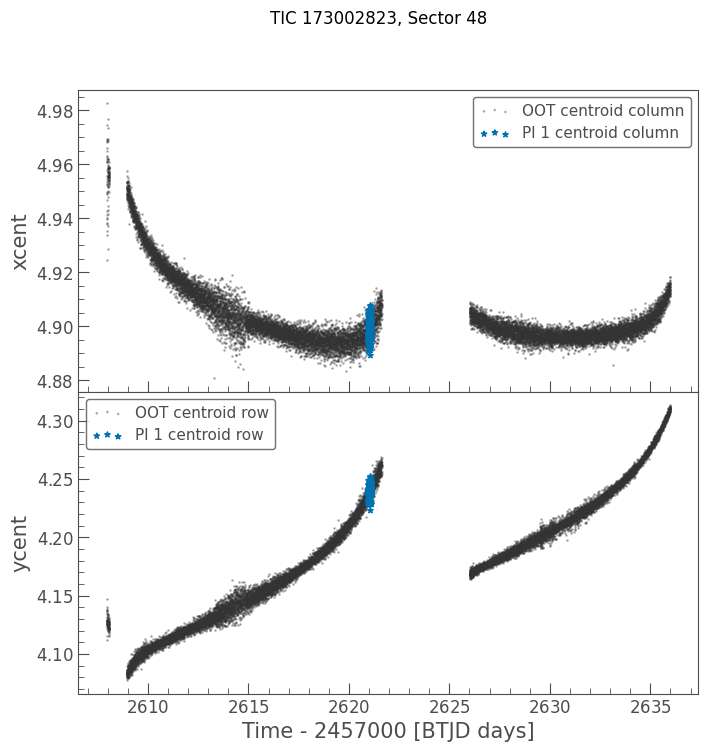

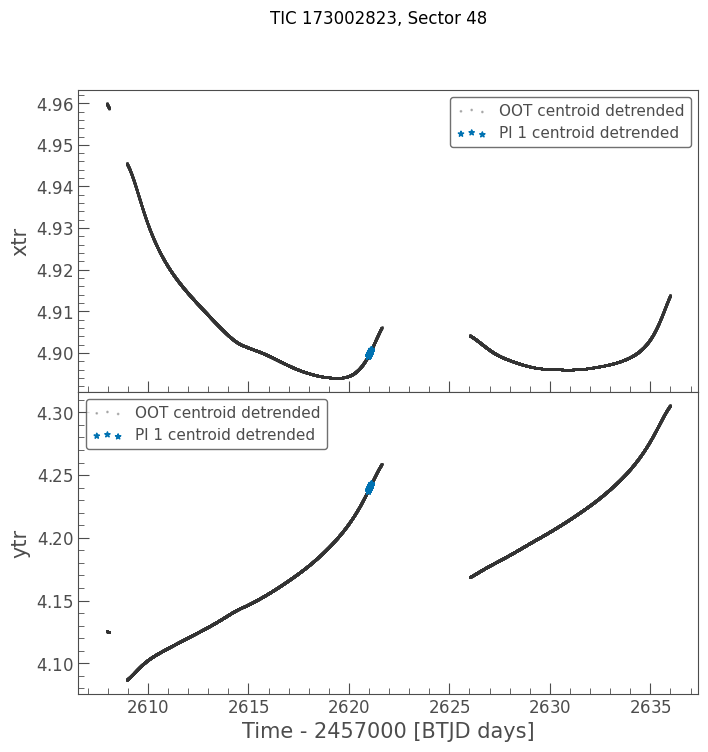

In [10]:
# plot estimated centroids / detrended centroids to check if the detrending is over/under aggressive
for i in [0, 1]: 
    lc = r['lc_list'][i]
    label = vt.centroiding._label(tpfs[i])
    fig1 = vt.centroiding.plot_centroids_vs_time(lc, "cent", label=label);
    fig2 = vt.centroiding.plot_centroids_vs_time(lc, "tr", label=label);

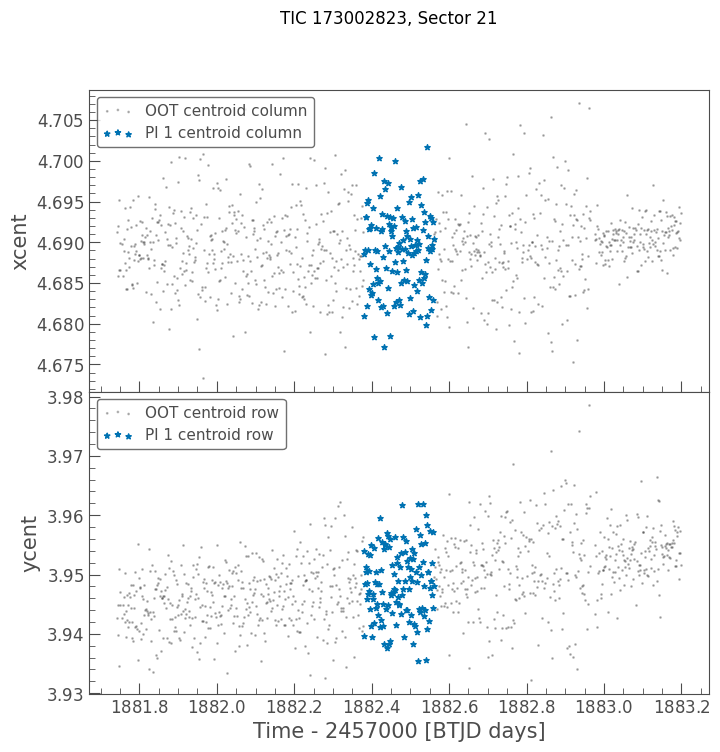

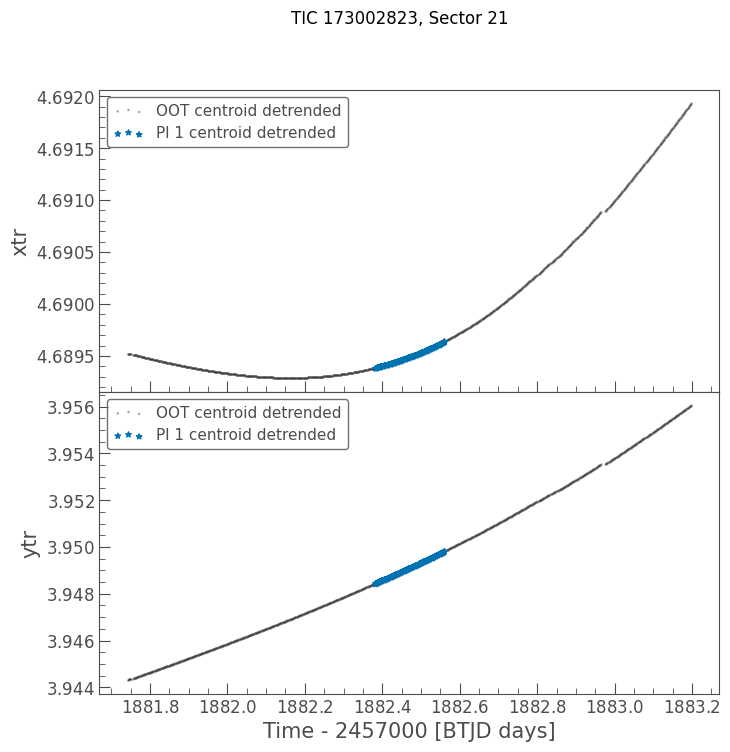

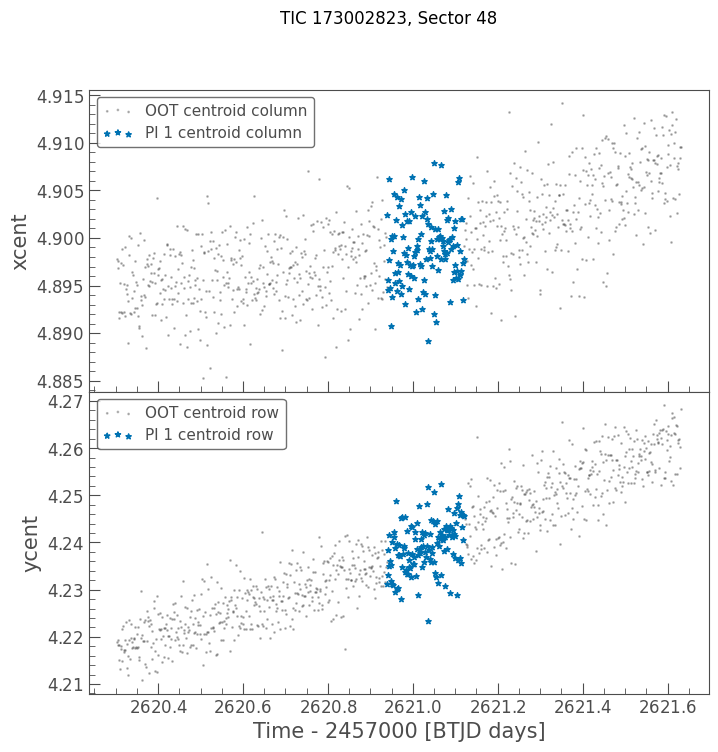

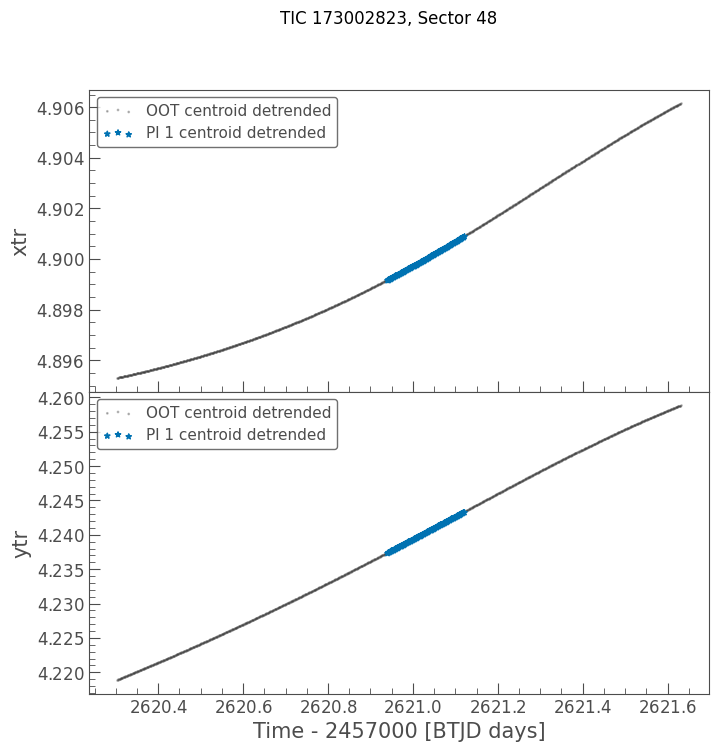

In [11]:
# zoom in to a dip to inspect again
t0s = [t0 - period * 32, t0] 

for i in [0, 1]: 
    lc = r['lc_list'][i].truncate(t0s[i] - duration * 4, t0s[i] + duration * 4)
    label = vt.centroiding._label(tpfs[i])
    fig1 = vt.centroiding.plot_centroids_vs_time(lc, "cent", label=label);
    fig2 = vt.centroiding.plot_centroids_vs_time(lc, "tr", label=label);